<a href="https://colab.research.google.com/github/johnsunbuns/GansResearch/blob/master/FID_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.transforms.functional as F
from PIL import ImageFilter
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

import math
import torch.nn.functional as Fn
from torch.autograd import Variable
from torchvision.models import inception_v3
import scipy

In [2]:
ngpu = 1
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Our trained control group DCGAN on mnist dataset

Parameters for loading the control-group GAN model and its input data


In [3]:
# Number of channels in the training images. 3 for color images and 1 for grayscale images.
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Constant noise vector. This is fine since we only do one forward pass of the network in this notebook.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

Defining the control group GAN model architecture

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
  
            nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
    
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
    
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

Load the trained model parameters into a new instance of the generator class

In [5]:
model = Generator()
os.chdir('/content/drive/My Drive/models/mnist_dcgan')
model.load_state_dict(torch.load('model3.pth', map_location=device))

<All keys matched successfully>

## Results of the control group GAN


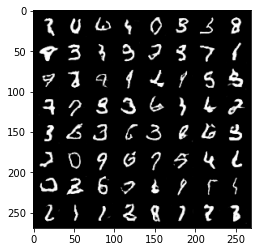

In [6]:
with torch.no_grad():
    fake_image = model(fixed_noise).to(device)
    plt.imshow(np.transpose(vutils.make_grid(fake_image, padding = 5, normalize=True), (1, 2, 0)))

As you can see, our control group gan is able to produce images that look somewhat similar to human digits, with some of the generated images looking exactly like actual numbers. However there are some images that look not realistic at all, and the images are still only 28 x 28 and grayscale. With the stack gan we hope to achieve more realistic images on better resolutions and on rgb.

## FID score

In [7]:
# inception v3 feature extractor
class PartialInceptionNetwork(torch.nn.Module):
    def __init__(self):
        # trigger parent constructor
        super(PartialInceptionNetwork, self).__init__()

        # initialize pretrained network
        self.inception_network = inception_v3(pretrained=True)

        # register a forward hook 
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)

    # a hook allows you to give you the output of the internal block directly when you 
    # pass the inputs through the forward method. (Pytorch specific)
    def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output 

    def forward(self, x):
        """
        Args:
            x: shape (N, 3, 299, 299) 
        Returns:
            inception activations: shape (N, 2048)
        """
        assert x.shape[1:] == (3, 299, 299)

        # Trigger output hook
        self.inception_network(x)

        # Output: N x 2048 x 8 x 8
        activations = self.mixed_7c_output

        # Output: N x 2048 x 1 x 1
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1, 1))

        # Rectify dimension
        activations = activations.view(x.shape[0], 2048)

        return activations

net = PartialInceptionNetwork()

In [8]:
def fid_score(real_images, gen_images, batch_size):

    # list of features
    real_activations = []
    gen_activations = []

    # number of steps
    num_steps = int(math.ceil(float(len(real_images)) / float(batch_size)))

    # iterate over the images
    for i in range(num_steps):

        # mini-batch start and end index
        start = i * batch_size
        end = (i + 1) * batch_size

        # mini-batch images
        mini_batch_real = real_images[start:end]
        mini_batch_gen = gen_images[start:end]

        # mini-batch as Torch tensor with gradients
        batch_real = Variable(mini_batch_real)
        batch_gen = Variable(mini_batch_gen)

        # apply a forward pass through inception network
        features_real = net(batch_real)
        features_gen = net(batch_gen)

        # accumulate features
        real_activations.append(features_real)
        gen_activations.append(features_gen)

    # stack tensor
    features_real = torch.cat(real_activations, 0)
    featrues_gen = torch.cat(gen_activiations, 0)

    # tensor to numpy 
    xr = features_real.detach().numpy()
    xg = features_gen.detach().numpy()

    # calculate mean
    u1 = np.mean(xr, axis=0)
    u2 = np.mean(xg, axis=0)

    # calculate variance
    s1 = np.cov(xr, rowvar=False)
    s2 = np.cov(xg, rowvar=False)

    # difference squared
    diff = u1 - u2
    diff_squared = diff.dot(diff)

    # trace covariance product
    prod = s1.dot(s2)
    sqrt_prod, _ = scipy.linalg.sqrtm(prod, disp=False)

    # avoid imaginary numbers
    if np.iscomplexobj(sqrt_prod):
        sqrt_prod = sqrt_prod.real

    prod_tr = np.trace(sqrt_prod)

    # calculate FID
    final_score = diff_squared + np.trace(s1) + np.trace(s2) - 2 * prod_tr

    # return FID score
    return final_score

In [9]:
# REAL images

# load mini batch from real dataset
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = MNIST(root='./data/', train=True, download=True, transform=trans)
trainloader = DataLoader(trainset, batch_size=64)
images,_ = next(iter(trainloader))

# reshape to 1x28x28
images = images.view(-1, 1, 28, 28)

# repeat gray channel to RGB
images = images.repeat(1, 3, 1, 1)

# resize the images to 3x299x299
real_res_images = Fn.interpolate(images, size=(299,299))

In [ ]:
BATCH_SIZE = 64
# Generated images

# Generated Images, same process
images = model(fixed_noise)
images = images.view(-1, 1, 28, 28)
images = images.repeat(1, 3, 1, 1)
gen_res_images = Fn.interpolate(images, size=(299, 299))

# calculate inception score

# FID score between two identical distrubtions should be 0
same_score = fid_score(real_res_images, real_res_images, BATCH_SIZE)

# FID score between the real and fake images should be positive
different_score = fid_score(real_res_images, gen_real_iamges, BATCH_SIZE)

print(f'identical images score: {same_score}')
print(f'generated images score: {different_score}')